# Modeling

This notebook covers:
- Data loading and preparation
- Feature engineering
- Train/test split
- Model training (Logistic Regression baseline, Gradient Boosting)
- Model evaluation and comparison
- Initial performance metrics (discrimination)

Note: Probability calibration will be handled in notebook 03.


In [40]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score,
    log_loss, brier_score_loss,
    confusion_matrix, classification_report
)

# Import project utilities
import sys
from pathlib import Path
# Add project root to path (notebooks are in notebooks/ folder, src is in parent)
project_root = Path(__file__).parent.parent if '__file__' in globals() else Path('../').resolve()
sys.path.insert(0, str(project_root))
from src import data, features, model, eval, viz

warnings.filterwarnings('ignore')

# Set style
viz.set_plot_style()

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Load Data


In [41]:
# Load the dataset
data_path = Path('../data/raw/high_diamond_ranked_10min.csv')
df = data.load_data(data_path)

print(f"Dataset shape: {df.shape}")
print(f"Loaded {len(df):,} games")


Dataset shape: (9879, 40)
Loaded 9,879 games


## 2. Prepare Target and Features


In [42]:
# Separate target and features
target = 'blueWins'
X, y = data.prepare_target_features(df, target=target, exclude_cols=['gameId'])

print(f"Features shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts(normalize=True))


Features shape: (9879, 38)
Target distribution:
blueWins
0    0.500962
1    0.499038
Name: proportion, dtype: float64


## 3. Feature Engineering

Based on the README, we can create derived features such as:
- Objective advantage deltas (Blue - Red)
- Resource advantage ratios
- Normalized rates


In [43]:
# Apply feature engineering
df_eng = features.create_engineered_features(df)

# Update X with engineered features (exclude gameId and target)
X = df_eng.drop(columns=[target, 'gameId']).copy()

print(f"Features after engineering: {X.shape[1]} features")
print(f"\nNew engineered features:")
engineered_cols = [col for col in X.columns if 'Advantage' in col]
print(f"  Total engineered features: {len(engineered_cols)}")
print(f"  Sample: {engineered_cols[:5]}")


Features after engineering: 50 features

New engineered features:
  Total engineered features: 12
  Sample: ['blueKillAdvantage', 'blueDeathAdvantage', 'blueAssistAdvantage', 'blueDragonAdvantage', 'blueHeraldAdvantage']


## 4. Train/Test Split


In [44]:
# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTraining target distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTest target distribution:")
print(y_test.value_counts(normalize=True))


Training set: 7,903 samples (80.0%)
Test set: 1,976 samples (20.0%)

Training target distribution:
blueWins
0    0.500949
1    0.499051
Name: proportion, dtype: float64

Test target distribution:
blueWins
0    0.501012
1    0.498988
Name: proportion, dtype: float64


## 5. Model Training

We'll train two models:
1. **Baseline**: Logistic Regression (interpretable benchmark)
2. **Strong Baseline**: Histogram-based Gradient Boosting (sklearn's HistGradientBoostingClassifier)


In [45]:
# Initialize models
models = {}

# 1. Logistic Regression (baseline)
# Note: Logistic Regression benefits from feature scaling
scaler = model.prepare_scaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training Logistic Regression...")
lr_model = model.create_logistic_regression(random_state=RANDOM_STATE)
lr_model.fit(X_train_scaled, y_train)
models['Logistic Regression'] = {
    'model': lr_model,
    'scaler': scaler,
    'needs_scaling': True
}

print("Training Histogram-based Gradient Boosting...")
# Use early stopping and regularization to prevent overfitting
hgb_model = model.create_hist_gradient_boosting(random_state=RANDOM_STATE)
hgb_model.fit(X_train, y_train)
models['HistGradientBoosting'] = {
    'model': hgb_model,
    'scaler': None,
    'needs_scaling': False
}

print("\n[OK] All models trained successfully")


Training Logistic Regression...
Training Histogram-based Gradient Boosting...

[OK] All models trained successfully


## 6. Model Predictions


In [46]:
# Generate predictions for all models
predictions = {}

for name, model_dict in models.items():
    model = model_dict['model']
    scaler = model_dict['scaler']
    needs_scaling = model_dict['needs_scaling']
    
    # Prepare data
    if needs_scaling:
        X_train_pred = scaler.transform(X_train)
        X_test_pred = X_test_scaled
    else:
        X_train_pred = X_train
        X_test_pred = X_test
    
    # Get probabilities
    y_train_proba = model.predict_proba(X_train_pred)[:, 1]
    y_test_proba = model.predict_proba(X_test_pred)[:, 1]
    
    # Get binary predictions (threshold = 0.5)
    y_train_pred = model.predict(X_train_pred)
    y_test_pred = model.predict(X_test_pred)
    
    predictions[name] = {
        'train_proba': y_train_proba,
        'test_proba': y_test_proba,
        'train_pred': y_train_pred,
        'test_pred': y_test_pred
    }
    
    print(f"[OK] Predictions generated for {name}")

print(f"\nPredictions shape (test): {predictions['Logistic Regression']['test_proba'].shape}")


[OK] Predictions generated for Logistic Regression
[OK] Predictions generated for HistGradientBoosting

Predictions shape (test): (1976,)


## 7. Model Evaluation - Discrimination Metrics

We evaluate models on discrimination metrics:
- ROC-AUC
- PR-AUC (Precision-Recall AUC)
- Log Loss
- Brier Score


In [47]:
# Calculate metrics for all models
results = []

for name, preds in predictions.items():
    # Test set metrics
    roc_auc = roc_auc_score(y_test, preds['test_proba'])
    pr_auc = average_precision_score(y_test, preds['test_proba'])
    logloss = log_loss(y_test, preds['test_proba'])
    brier = brier_score_loss(y_test, preds['test_proba'])
    
    # Training set metrics (for comparison)
    roc_auc_train = roc_auc_score(y_train, preds['train_proba'])
    logloss_train = log_loss(y_train, preds['train_proba'])
    
    results.append({
        'Model': name,
        'ROC-AUC (Test)': roc_auc,
        'PR-AUC (Test)': pr_auc,
        'Log Loss (Test)': logloss,
        'Brier Score (Test)': brier,
        'ROC-AUC (Train)': roc_auc_train,
        'Log Loss (Train)': logloss_train
    })

results_df = pd.DataFrame(results)
results_df = results_df.round(4)

print("Model Performance Comparison:")
print("=" * 80)
print(results_df.to_string(index=False))
print("=" * 80)


Model Performance Comparison:
               Model  ROC-AUC (Test)  PR-AUC (Test)  Log Loss (Test)  Brier Score (Test)  ROC-AUC (Train)  Log Loss (Train)
 Logistic Regression          0.8058         0.8049           0.5318              0.1799           0.8135            0.5260
HistGradientBoosting          0.8024         0.8048           0.5355              0.1819           0.8548            0.4759


## 8. ROC Curves


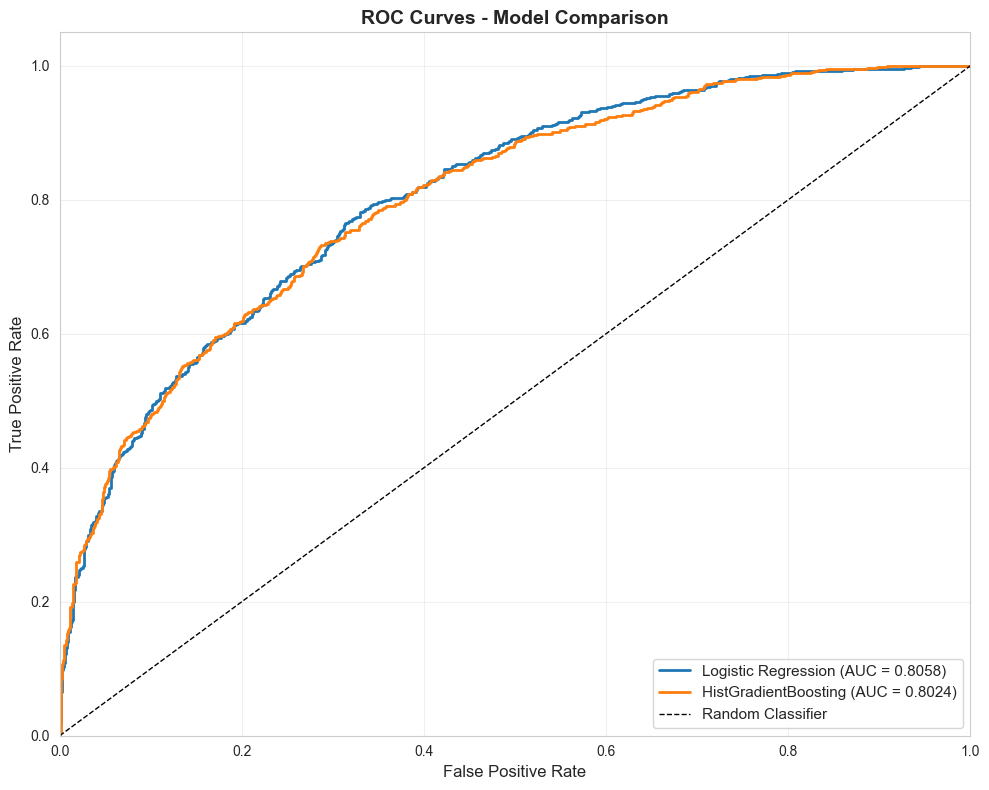

In [48]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for name, preds in predictions.items():
    fpr, tpr, _ = roc_curve(y_test, preds['test_proba'])
    roc_auc = roc_auc_score(y_test, preds['test_proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 9. Precision-Recall Curves


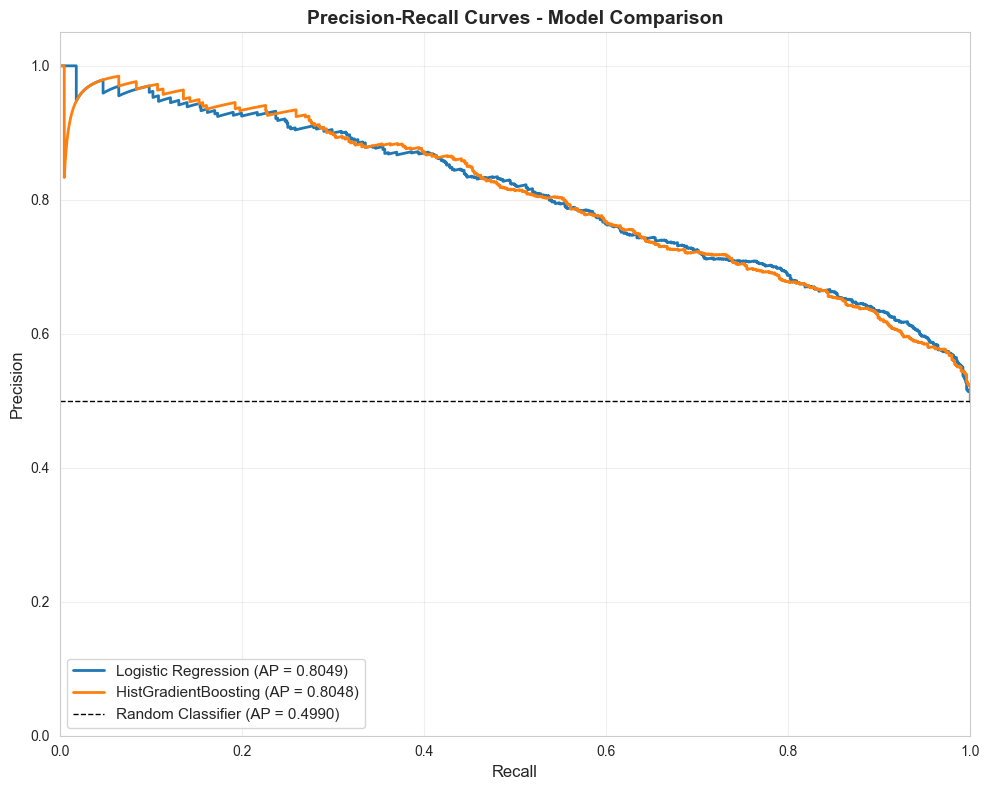

In [49]:
# Plot Precision-Recall curves for all models
plt.figure(figsize=(10, 8))

for name, preds in predictions.items():
    precision, recall, _ = precision_recall_curve(y_test, preds['test_proba'])
    pr_auc = average_precision_score(y_test, preds['test_proba'])
    plt.plot(recall, precision, label=f'{name} (AP = {pr_auc:.4f})', linewidth=2)

# Baseline (random classifier)
baseline = y_test.mean()
plt.axhline(y=baseline, color='k', linestyle='--', label=f'Random Classifier (AP = {baseline:.4f})', linewidth=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 10. Confusion Matrices


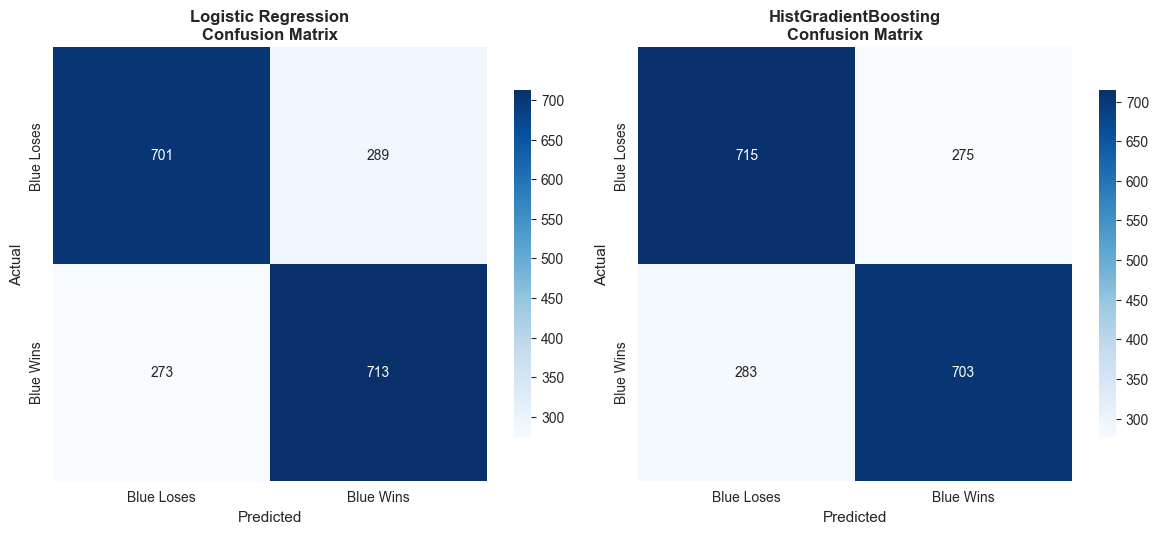

In [50]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(1, len(models), figsize=(6*len(models), 5))

for idx, (name, preds) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, preds['test_pred'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                cbar_kws={'shrink': 0.8}, square=True)
    axes[idx].set_title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=11)
    axes[idx].set_ylabel('Actual', fontsize=11)
    axes[idx].set_xticklabels(['Blue Loses', 'Blue Wins'])
    axes[idx].set_yticklabels(['Blue Loses', 'Blue Wins'])

plt.tight_layout()
plt.show()


## 11. Classification Reports


In [51]:
# Print detailed classification reports
for name, preds in predictions.items():
    print(f"\n{'='*60}")
    print(f"Classification Report: {name}")
    print(f"{'='*60}")
    print(classification_report(y_test, preds['test_pred'], 
                              target_names=['Blue Loses', 'Blue Wins']))



Classification Report: Logistic Regression
              precision    recall  f1-score   support

  Blue Loses       0.72      0.71      0.71       990
   Blue Wins       0.71      0.72      0.72       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976


Classification Report: HistGradientBoosting
              precision    recall  f1-score   support

  Blue Loses       0.72      0.72      0.72       990
   Blue Wins       0.72      0.71      0.72       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976



## 12. Model Comparison Summary


In [52]:
# Create a comprehensive comparison
print("=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)

# Display results table
print("\nPerformance Metrics (Test Set):")
print(results_df[['Model', 'ROC-AUC (Test)', 'PR-AUC (Test)', 'Log Loss (Test)', 'Brier Score (Test)']].to_string(index=False))

# Identify best model for each metric
print("\n" + "=" * 80)
print("Best Models by Metric:")
print("=" * 80)
print(f"  Best ROC-AUC: {results_df.loc[results_df['ROC-AUC (Test)'].idxmax(), 'Model']} ({results_df['ROC-AUC (Test)'].max():.4f})")
print(f"  Best PR-AUC: {results_df.loc[results_df['PR-AUC (Test)'].idxmax(), 'Model']} ({results_df['PR-AUC (Test)'].max():.4f})")
print(f"  Best Log Loss: {results_df.loc[results_df['Log Loss (Test)'].idxmin(), 'Model']} ({results_df['Log Loss (Test)'].min():.4f})")
print(f"  Best Brier Score: {results_df.loc[results_df['Brier Score (Test)'].idxmin(), 'Model']} ({results_df['Brier Score (Test)'].min():.4f})")

# Check for overfitting
print("\n" + "=" * 80)
print("Overfitting Check (Train vs Test ROC-AUC):")
print("=" * 80)
for _, row in results_df.iterrows():
    train_auc = row['ROC-AUC (Train)']
    test_auc = row['ROC-AUC (Test)']
    diff = train_auc - test_auc
    status = "[OK]" if diff < 0.05 else "[WARNING]"
    print(f"  {row['Model']}: Train={train_auc:.4f}, Test={test_auc:.4f}, Diff={diff:.4f} {status}")

print("\n" + "=" * 80)
print("\nNote: Probability calibration will be evaluated in notebook 03.")
print("=" * 80)


MODEL COMPARISON SUMMARY

Performance Metrics (Test Set):
               Model  ROC-AUC (Test)  PR-AUC (Test)  Log Loss (Test)  Brier Score (Test)
 Logistic Regression          0.8058         0.8049           0.5318              0.1799
HistGradientBoosting          0.8024         0.8048           0.5355              0.1819

Best Models by Metric:
  Best ROC-AUC: Logistic Regression (0.8058)
  Best PR-AUC: Logistic Regression (0.8049)
  Best Log Loss: Logistic Regression (0.5318)
  Best Brier Score: Logistic Regression (0.1799)

Overfitting Check (Train vs Test ROC-AUC):
  Logistic Regression: Train=0.8135, Test=0.8058, Diff=0.0077 [OK]
  HistGradientBoosting: Train=0.8548, Test=0.8024, Diff=0.0524 [WARNING]


Note: Probability calibration will be evaluated in notebook 03.
